### Pig grunts audio classification

In [1]:
import torch
import torchaudio
import IPython
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from torch import nn
from torchsummary import summary
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.model_selection import train_test_split
from pprint import pprint


#from torchvision import transforms


from model import *
from functions import *


print(torch.__version__)
print(torchaudio.__version__)

2.1.0
2.1.0


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# directory_path = os.path.join(os.getcwd(), 'Dataset')
# # directory_path = os.getcwd()

# # Get the list of all contents in the directory (all audio files)
# contents = os.listdir(directory_path)
# print(f"Contents of the directory '{directory_path}':")
# file_paths = []
# for item in tqdm(contents):
#     file_path = os.path.join(directory_path, item)  # Full path to the file
#     file_paths.append(file_path)
#     wvf, sample_rate = torchaudio.load(file_path)
#     print(f"Loaded: {item} | Sample Rate: {sample_rate} | Shape: {wvf.shape}")
# #     break

In [ ]:
# labels = []
# for element in tqdm(file_paths):
#     name = element[:-4]
#     label = int(name[-1])
#     labels.append(label)


In [ ]:
# check the number of samples in the audios

# wvf, sample_rate, label, spectro = dataset[1700]
# print(wvf.shape)
# print(wvf.shape[1]/sample_rate)
# print(f'max : {max(waveforms_val)}')
# print(f'min : {min(waveforms_val)}')
# a = len([val for val in waveforms_val if val > 98000])
# print("Number of values above the threshold:", a)

In [4]:
# set all the parameters

data_path = os.path.join(os.getcwd(), 'Dataset')

fixed_sample_rate = 48000 #16000
num_samples = 98000 #16000
n_fft = 1024 #512 #1024
hop_length = 512
n_mels = 128 #64
n_mfcc = 40


transfo_mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=fixed_sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        mel_scale="htk")

transfo_mfcc = torchaudio.transforms.MFCC(
        sample_rate=fixed_sample_rate,
        n_mfcc=n_mfcc,
        dct_type=2,
        norm='ortho',
        log_mels=False)

transfo_spectro = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        hop_length = hop_length,
        power=2.0,
        normalized=False,
        center=True,
        pad_mode='reflect',
        onesided=True,
        return_complex=None)

C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [5]:
# choose which transformation to apply to the waveforms + adjust necessary parameters/variables :

transfo_applied = 'spectrogram'
# transfo_applied = 'mel_spectrogram'
# transfo_applied = 'mfcc'


if transfo_applied == 'spectrogram':
    transformation = transfo_spectro
    cnn = CNN_spectro()
    best_model = CNN_spectro()
    random_tensor = torch.rand([64,1,513,192]).to(device)

elif transfo_applied == 'mel_spectrogram' :
    transformation = transfo_mel
    cnn = CNN_mel()
    best_model = CNN_mel()
    random_tensor = torch.rand([64,1,128,32]).to(device)

elif transfo_applied == 'mfcc':
    transformation = transfo_mfcc
    cnn = CNN_mfcc()
    best_model = CNN_mfcc()
    random_tensor = torch.rand([64,1,40,81]).to(device)


In [52]:
# Create the custom dataset class + apply transformation to the data

    
class PigsAudioDataset(Dataset):
    def __init__(self, data_path, transformation, target_sample_rate, nr_samples):

        self.audio_dir = data_path
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.nr_samples = nr_samples
        
    def __len__(self):
        folder_contents = os.listdir(self.audio_dir)
        return len(folder_contents)

    def __getitem__(self, idx):
        
        list_audio_paths, audio_path = self._get_audio_paths(self.audio_dir, idx)
        label = self._get_label(list_audio_paths, idx)
        
        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        waveform = self._resample(waveform, sample_rate)
        waveform = self._mix_down(waveform)
        waveform = self._trim(waveform)
        waveform = self._zero_pad(waveform)
        waveform = self._normalize(waveform)  # Apply normalization
        transfo = self.transformation(waveform)
        
        return waveform, sample_rate, label, transfo


    def _get_audio_paths(self, directory_path, idx):
        # Get the list of all contents (files and directories) in the directory
        contents = os.listdir(directory_path)
        file_paths = []
        for item in contents:
            file_path = os.path.join(directory_path, item)  # Full path to the file
            file_paths.append(file_path)

        return file_paths, file_paths[idx]
    
    def _get_label(self, file_paths, idx):
        
        labels = []
        for element in file_paths:
            name = element[:-4]
            label = int(name[-1])
            labels.append(label)
        
        return labels[idx]


    def _resample(self, wvf, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            wvf = resampler(wvf)
        return wvf

    def _mix_down(self, wvf):
        if wvf.shape[0] > 1:
            wvf = torch.mean(wvf, dim=0, keepdim=True)
        return wvf

    def _trim(self, wvf):
        if wvf.shape[1] > self.nr_samples :
            excess_samples = wvf.shape[1] - self.nr_samples
            left_trim = excess_samples // 2
            right_trim = excess_samples - left_trim
            wvf = wvf[:, left_trim:-right_trim]
        return wvf

    def _zero_pad(self, wvf):
        if wvf.shape[1] < self.nr_samples :
            nr_missing_samples = self.nr_samples - wvf.shape[1]
            wvf = torch.nn.functional.pad(wvf, (0, nr_missing_samples))
        return wvf
    
    def _normalize(self, wvf):
        # Min-max scaling to range [0, 1]
        min_val = torch.min(wvf)
        max_val = torch.max(wvf)
        normalized_wvf = (wvf - min_val) / (max_val - min_val + 1e-8)  # Adding small epsilon to avoid division by zero
        
        return normalized_wvf



In [53]:
# Create an instance of the dataset
dataset = PigsAudioDataset(data_path, transfo_spectro, fixed_sample_rate, num_samples)

In [54]:
# Split dataset into train, test and validation subsets
generator = torch.Generator().manual_seed(453)
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15], generator=generator)

In [55]:
print( f'nr of observations in train set : {len(train_dataset)}')
print( f'nr of observations in test set : {len(test_dataset)}')
print( f'nr of observations in validation set : {len(val_dataset)}')
# print(f'total length : {len(train_dataset)+len(test_dataset)+len(val_dataset)}')
print(f'total length : {len(dataset)}')

nr of observations in train set : 1223
nr of observations in test set : 262
nr of observations in validation set : 261
total length : 1746


In [56]:
# Check that they all have the same sample rate and number of samples

samplerates = []
waveforms = []

for i in tqdm(range(len(dataset))):
    waveform, sr , _ , _ = dataset[i]
    waveforms.append(waveform.shape[1])
    samplerates.append(sr)


print(f'Same number of samples : {all(wf == waveforms[0] for wf in waveforms)}')    
print(f'Same sample rate : {all(sr == samplerates[0] for sr in samplerates)}')    


100%|██████████████████████████████████████████████████████████████████████████████| 1746/1746 [00:31<00:00, 54.58it/s]

Same number of samples : True
Same sample rate : True


In [13]:
# # Visualize class distributions

# def class_distrib(dataset, dataset_name):
#     class_distribution = {}
#     total_samples = len(dataset)

#     for i, (_, _, label, _) in tqdm(enumerate(dataset)):
# #         label = label.item()
#         if label in class_distribution:
#             class_distribution[label] += 1
#         else:
#             class_distribution[label] = 1

#     class_distribution_percent = {label: count / total_samples * 100 for label, count in class_distribution.items()}
#     # class_distribution = dict(sorted(class_distribution.items()))
#     class_weights = {label: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()}
#     class_weights = dict(sorted(class_weights.items()))

#     plt.figure(figsize=(10, 6))
#     plt.bar(class_distribution_percent.keys(), class_distribution_percent.values())
#     plt.xlabel("Class Label")
#     plt.xticks(range(4))
#     plt.ylabel("Percentage of Samples")
#     plt.title(f"Class Distribution in {dataset_name} (in %)")
#     plt.show()
    
#     for key in class_distribution_percent:
#         class_distribution_percent[key] = round(class_distribution_percent[key])

#     pprint(class_distribution_percent)

#     return class_distribution_percent, class_weights

1746it [00:29, 59.85it/s]


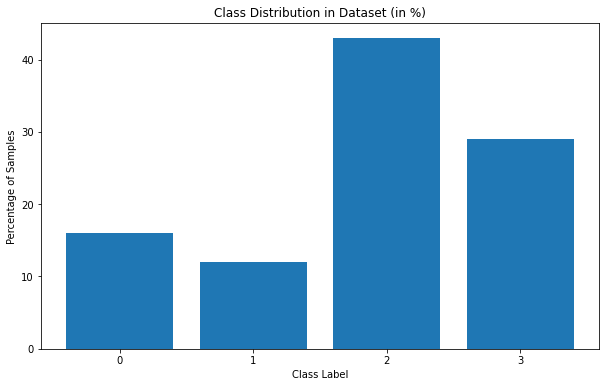

{0: 16, 1: 12, 2: 43, 3: 29}


In [14]:
# Class distribution of the entire dataset

class_distribution_percent, class_weights = class_distrib(dataset, 'Dataset')

262it [00:04, 61.97it/s]


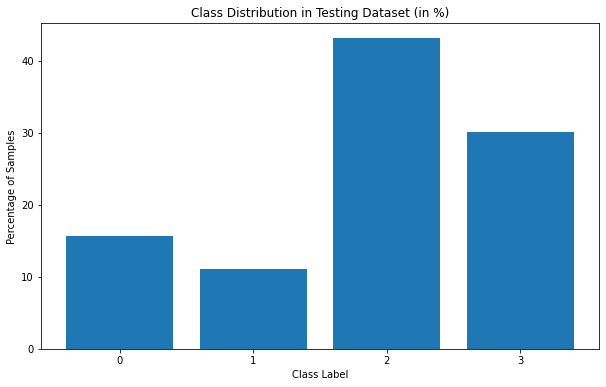

{0: 16, 1: 11, 2: 43, 3: 30}


261it [00:04, 57.42it/s]


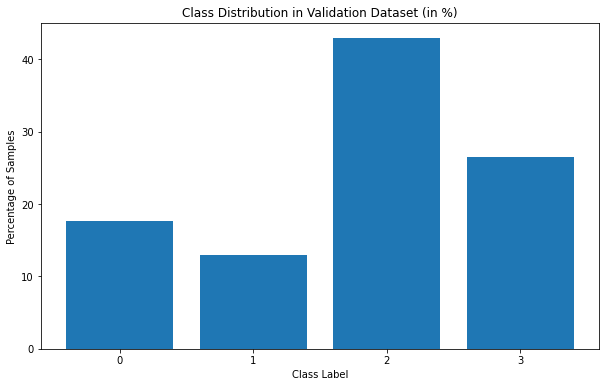

{0: 18, 1: 13, 2: 43, 3: 26}


1223it [00:20, 60.42it/s]


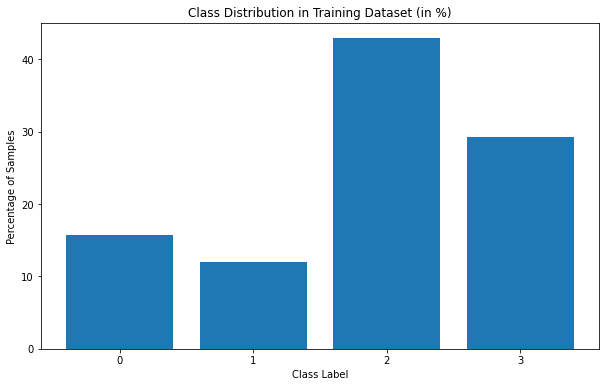

{0: 16, 1: 12, 2: 43, 3: 29}


In [15]:
# Check if the dataset is balanced over all the classes in the different subsets

class_distribution_percent_test, class_weights_test = class_distrib(test_dataset, 'Testing Dataset')
class_distribution_percent_val, class_weights_val = class_distrib(val_dataset, 'Validation Dataset')
class_distribution_percent_train, class_weights_train = class_distrib(train_dataset, 'Training Dataset')


In [18]:
# def class_weights_tensor(class_weights_dict) :
#     weights_list = [class_weights_dict[i] for i in range(len(class_weights_dict))]
#     class_weights_tensor = torch.tensor(weights_list, dtype=torch.float).to(device)
    
#     return class_weights_tensor

In [60]:
# Convert the class_weights dictionary to a tensor (for the loss)

class_weights_train_tensor = class_weights_tensor(class_weights_train)
class_weights_test_tensor = class_weights_tensor(class_weights_test)
class_weights_val_tensor = class_weights_tensor(class_weights_val)

Dataset train - Number of Samples: 1223
Dataset test - Number of Samples: 262
Dataset val - Number of Samples: 261


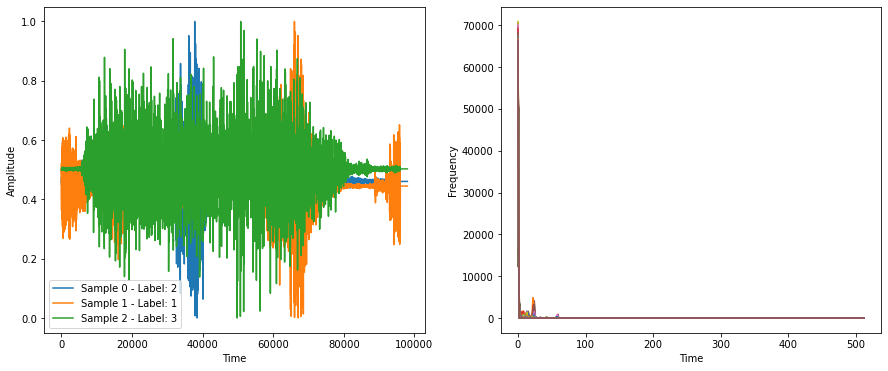

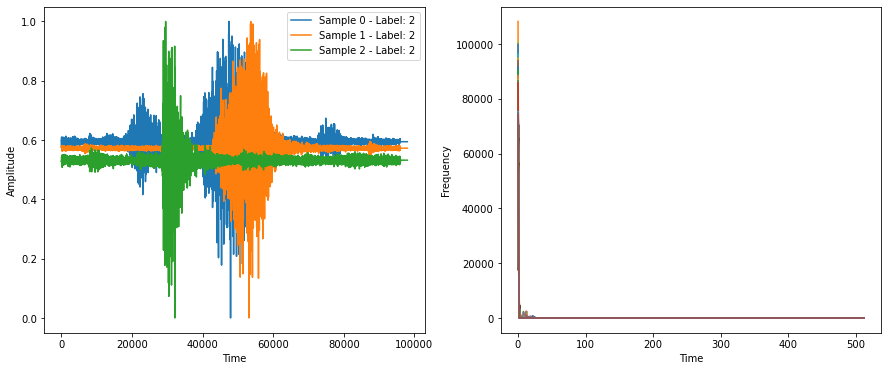

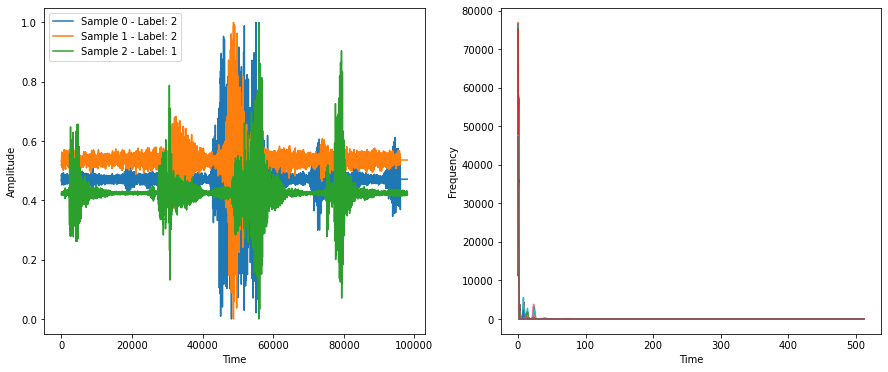

In [61]:
# see what's inside (plot waveforms and mel_spectrograms)
number_of_samples = 3
dataset_names = ["train", "test", "val"]
datasets = [train_dataset, test_dataset, val_dataset]

for dataset, dataset_name in zip(datasets, dataset_names):

    plt.figure(figsize=(15,6))
    print(f"Dataset {dataset_name} - Number of Samples: {len(dataset)}")

    plt.clf()
    plt.title(f"Dataset {dataset_name}")

    ax = plt.subplot(121)
    for i in range(number_of_samples):
        waveform, sample_rate, label, _ = dataset[i]
        ax.plot(waveform.t(), label=f"Sample {i} - Label: {label}")
        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()

    ax = plt.subplot(122)
    for i in range(number_of_samples):
        waveform, sample_rate, label, transform = dataset[i]
        ax.plot(transform.squeeze(), label=f"Sample {i} - Label: {label}")
#        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Frequency")

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


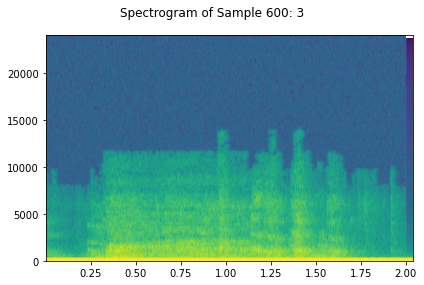

In [62]:
i = 600
waveform, sample_rate, label, _ = train_dataset[i]
plot_specgram(waveform, sample_rate, title=f"Spectrogram of Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)

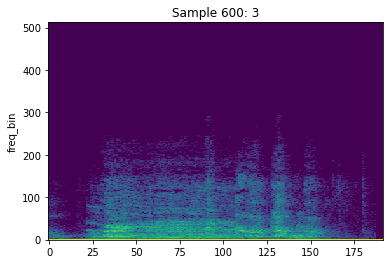

In [63]:
i = 600
waveform, sample_rate, label, _ = train_dataset[i]
plot_spectrogram(torchaudio.transforms.Spectrogram(n_fft=1024)(waveform).squeeze(), title=f"Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)


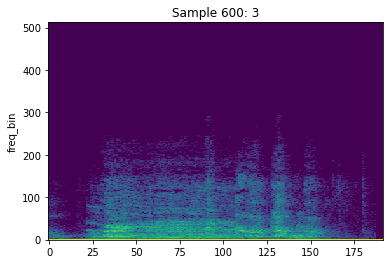

In [64]:
# Same as before
i = 600
waveform, sample_rate, label, spectrogram = train_dataset[i]
plot_spectrogram(spectrogram[0], title=f"Sample {i}: {label}") #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


In [65]:
# load the data into DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# # Build the model
# class CNN_spectro(nn.Module):

#     def __init__(self):
#         super().__init__()
#         # 4 conv blocks / flatten / linear / softmax
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1,
#                 out_channels=8,
#                 kernel_size=3,
#                 stride=1,
#                 padding=0
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=8,
#                 out_channels=16,
#                 kernel_size=5,
#                 stride=1,
#                 padding=0
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=16,
#                 out_channels=32,
#                 kernel_size=3,
#                 stride=1,
#                 padding=0
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=32,
#                 out_channels=64,
#                 kernel_size=3,
#                 stride=1,
#                 padding=0
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.flatten = nn.Flatten()
        
#         self.fc1 = nn.Linear(40992, 128)
#         self.fc2 = nn.Linear(128,64)
#         self.fc3 = nn.Linear(64,4)
#         self.softmax = nn.Softmax(dim=1)


#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
# #         x = self.conv4(x)
#         x = self.flatten(x)
# #         print(x.shape)
#         x = nn.ReLU()(self.fc1(x))
#         x = nn.ReLU()(self.fc2(x))
#         x = self.fc3(x)
        
#         predictions = self.softmax(x)

#         return x


In [66]:
# if transfo_applied == 'mel_spectrogram' :
#     cnn = CNN()
# elif transfo_applied == 'mfcc':
#     cnn = CNN_mfcc()
# elif transfo_applied == 'spectrogram':
#     cnn = CNN_spectro()

cnn.to(device)

# train_criterion = nn.CrossEntropyLoss(weight=class_weights_train_tensor)
# test_criterion = nn.CrossEntropyLoss(weight=class_weights_test_tensor)
# val_criterion = nn.CrossEntropyLoss(weight=class_weights_val_tensor)


train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss()
val_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)


In [67]:
train_dataset[0][3].shape

torch.Size([1, 513, 192])

In [68]:
# Model summary
input_size = train_dataset[0][3].shape
summary(cnn, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 511, 190]              80
              ReLU-2          [-1, 8, 511, 190]               0
         MaxPool2d-3           [-1, 8, 255, 95]               0
            Conv2d-4          [-1, 16, 251, 91]           3,216
              ReLU-5          [-1, 16, 251, 91]               0
         MaxPool2d-6          [-1, 16, 125, 45]               0
            Conv2d-7          [-1, 32, 123, 43]           4,640
              ReLU-8          [-1, 32, 123, 43]               0
         MaxPool2d-9           [-1, 32, 61, 21]               0
          Flatten-10                [-1, 40992]               0
           Linear-11                  [-1, 128]       5,247,104
           Linear-12                   [-1, 64]           8,256
           Linear-13                    [-1, 4]             260
          Softmax-14                   

In [69]:
# try with a random tensor of the right dimensions

cnn(random_tensor)[0]
# cnn(torch.rand([64,1,128,32]).to(device))[0]
# cnn(torch.rand([64,1,40,81]).to(device))[0] # MFCC
# cnn(torch.rand([64,1,513,192]).to(device))[0] # spectrogram

tensor([-3.9590, -2.7253,  6.6342, -2.6550], grad_fn=<SelectBackward0>)

In [70]:
# train the network

n_epochs = 20
current_datetime = datetime.now()
date_string = current_datetime.strftime("%d.%m.%Y_%H-%M")
saving_path = f'outputs/{transfo_applied}_{n_epochs}_eps_{date_string}.pth'

train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(cnn, train_dataloader, val_dataloader, optimizer, train_criterion, val_criterion, device, n_epochs, saving_path)

Train Epoch: 0 [0/1223 (0%)]	Loss: 6.720646
Train Epoch: 0 [320/1223 (26%)]	Loss: 1.914679
Train Epoch: 0 [640/1223 (51%)]	Loss: 1.151799
Train Epoch: 0 [960/1223 (77%)]	Loss: 0.829164
epoch n.0 : Average Loss = 1.5425704943063931, Accuracy = 55.36%
epoch n.0 : Val Average Loss = 0.6811513718631532, Val Accuracy = 75.10%
Train Epoch: 1 [0/1223 (0%)]	Loss: 0.480827
Train Epoch: 1 [320/1223 (26%)]	Loss: 0.342865
Train Epoch: 1 [640/1223 (51%)]	Loss: 0.384787
Train Epoch: 1 [960/1223 (77%)]	Loss: 0.576825
epoch n.1 : Average Loss = 0.5242311144486452, Accuracy = 80.87%
epoch n.1 : Val Average Loss = 0.46514597369564903, Val Accuracy = 80.08%
Train Epoch: 2 [0/1223 (0%)]	Loss: 0.376747
Train Epoch: 2 [320/1223 (26%)]	Loss: 0.604767
Train Epoch: 2 [640/1223 (51%)]	Loss: 0.256638
Train Epoch: 2 [960/1223 (77%)]	Loss: 0.176602
epoch n.2 : Average Loss = 0.3254749671770976, Accuracy = 87.65%
epoch n.2 : Val Average Loss = 0.513024183611075, Val Accuracy = 78.16%
Train Epoch: 3 [0/1223 (0%)]	Lo

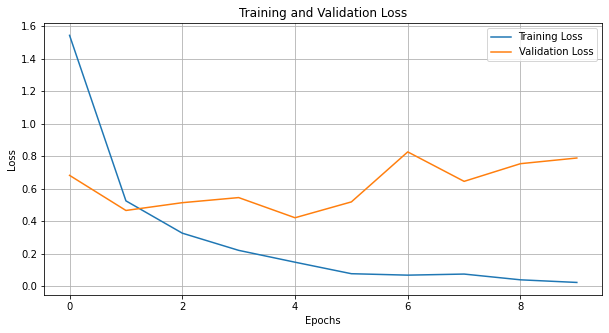

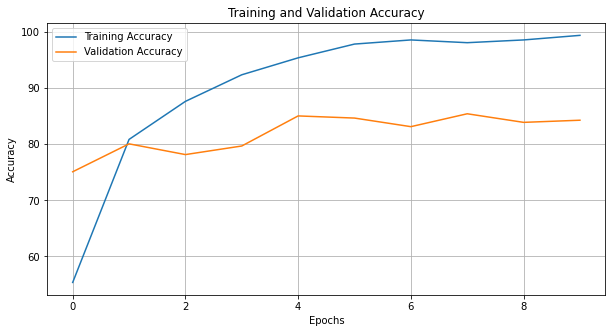

In [71]:
# plot learning curves

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/losses_{transfo_applied}_{date_string}.png"
plt.savefig(file_name, bbox_inches='tight', pad_inches=0.15,facecolor='white', transparent=False)
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/accuracies_{transfo_applied}_{date_string}.png"
plt.savefig(file_name, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=2)
plt.show()


In [72]:
# After training, to load the best model for inference or evaluation

# if transfo_applied == 'mel_spectrogram' :
#     best_model = CNN_mel()
# elif transfo_applied == 'mfcc':
#     best_model = CNN_mfcc()
# elif transfo_applied == 'spectrogram':
#     best_model = CNN_spectro()


state_dict = torch.load(saving_path, map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)

CNN_spectro(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=40992, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Sof

In [73]:
test_loss, test_accuracy = test_model(best_model, test_dataloader, test_criterion, device)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.29it/s]


Test set: Average loss: 0.0189, Accuracy: 230/262 (87.8%)



In [34]:
# def predict(model, input_data, target):
#     model.eval()
#     with torch.no_grad():
#         output = model(input_data.unsqueeze(dim=0))
#         pred = output.argmax(dim=1, keepdim=True)
#         predicted_label = pred.item()
#         expected_label = target
#     return predicted_label, expected_label


In [99]:
# Prediction/Inference on test data

i = random.randint(0,len(test_dataloader.dataset)-1)
input_data = test_dataloader.dataset[i][3].to(device)
target = test_dataloader.dataset[i][2] #.astype(np.int64)

predicted_label, expected_label = predict(best_model, input_data, target)
print(f"Predicted label : {predicted_label}, Expected label : {expected_label}")

Predicted label : 2, Expected label : 2


- Quand faut-il faire de la segmentation ?
- Si nombre de samples =/= (taille d'échant =/=) : trim ou pad, mais on peut aussi stretch ?
- Quand faut-il mieux utiliser une transformation en MelSpectrograms ou en mfcc ?
- Rajouter nn.Dropout() après chaque couche ?
- scheduler ?

- NORMALISATION / BATCH NORMALISATION ?